In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys

from dotenv import load_dotenv

# climb up until we hit the repo root, then add src
here = Path.cwd().resolve()
while here.name != "over-intra-news" and here.parent != here:
    here = here.parent

src_path = here / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

load_dotenv()

True

# Topic Coherence for LDA Models

This notebook computes topic coherence scores for a set of MALLET LDA runs trained on a
CC-NEWS–based corpus stored in Postgres. The goals are:

1. **Interpretability diagnostics.** Use coherence (primarily the $C_v$ measure from Röder
   et al., “Exploring the Space of Topic Coherence Measures”) as a *diagnostic and reporting
   tool* for topic interpretability, and as a **secondary tie-breaker** among LDA runs that
   already look similar in out-of-sample regression performance.

2. **Metadata persistence.** Persist per-topic metadata – top terms and coherence scores –
   into the relational schema (`lda_topic_metadata` and `lda_article_topic_exposure`)
   for downstream regression, labeling, and qualitative inspection.

We follow Röder’s decomposition of coherence into four components:

- **Segmentation** $S$: which word subsets we compare (e.g., all word pairs drawn from
  the top-$N$ terms of a topic).
- **Probability estimation** $P$: how we estimate word and co-occurrence probabilities
  from a reference corpus (here: boolean sliding windows over cleaned news text).
- **Confirmation measure** $M$: how strongly one subset supports another (e.g., NPMI).
- **Aggregation** $\Sigma$: how we fold many confirmations into a single topic-level
  score (e.g., averaging over all pairs).

The $C_v$ measure used here is realized via Gensim’s `CoherenceModel`, which instantiates
this $S, P, M, \Sigma$ framework with a specific configuration.

## Notebook roadmap

The notebook is split into four stages:

1. **Corpus sampling and cleaning**

   - Sample article IDs from Postgres, aligned to trading days and sessions.
   - Draw a **bounded random subsample** of articles (up to a configurable `subsample_size`)
     from this ID set to serve as the reference corpus for coherence.
   - Apply the same deterministic, multi-stage normalization and token canonicalization
     pipeline used to build the LDA training corpus.
   - Return a cleaned list of tokenized documents in the format expected by
     `CoherenceModel(texts=...)`.

2. **Top-word extraction per topic and run**

   - Load MALLET topic–word weight dumps (`K200_*.parquet`).
   - For each run and topic, extract the top-$N$ terms by weight in the order MALLET
     emits them.
   - Build a `List[List[str]]` per run in the exact format expected by
     `CoherenceModel(topics=...)`.

3. **Coherence estimation**

   - For each run, instantiate `CoherenceModel` with
     `topics` = that run’s top-word lists,
     `texts` = the cleaned reference corpus from Stage 1, and
     `dictionary` = a Gensim word-to-id `Dictionary` built from the same corpus.
   - Compute per-topic coherence scores and aggregate summaries (e.g., mean coherence
     per run) as interpretability diagnostics.

4. **Persistence to Postgres**

   - For each `(run_id, topic_id)` pair, write top terms and $C_v$ coherence into
     `lda_topic_metadata`.
   - For each `(run_id, article_id, topic_id)` triple, write topic exposures and a
     corpus version into `lda_article_topic_exposure`.


---

## 1. Corpus sampling and cleaning

The coherence computation needs a **reference corpus** that is consistent with the one used to train the LDA models. Rather than re-implementing a second cleaning stack, we reuse the same functions that produced the tokenized parquet chunks and `FrequencyCounters` for LDA ingestion.

### 1.1 Sampling article IDs by trading day and session

We first select a set of article IDs over a `[start_date, end_date]` window using `sample_corpus_per_day`:

- The function queries the `trading_calendar` table for all rows with:

  - `trading_day BETWEEN start_date AND end_date`, and  
  - `is_trading_day = TRUE`.

- For each trading day, it iterates over both **“overnight”** and **“intraday”** sessions, and for each `(day, session)` pair:

  - Pulls `article_id`, `language_confidence`, and `full_text` from `parsed_news_articles`.
  - Passes that day/session slice into `sample_per_day_session`, which applies:
    - **Boilerplate removal** via `NOISY_PREFIXES` (reject articles whose `full_text` starts with a known noisy prefix).
    - **Substring exclusion** via `NOISY_SUBSTRINGS` (reject articles containing well-known noise snippets).
    - **Language-quality filtering**: require `language_confidence ≥ STRONG_ENGLISH_CONFIDENCE_THRESHOLD`.

- The result is a **deduplicated set of article IDs** that pass basic quality filters across all trading days and sessions in the window.

This `sample_id_set` is the input to `extract_clean_corpus`.

### 1.2 Fetching raw text and chunking

`extract_clean_corpus` then materializes the raw articles and prepares them for cleaning:

1. It issues a single SQL query against `parsed_news_articles`:

   ```sql
   SELECT *
   FROM parsed_news_articles
   WHERE article_id = ANY(%(samples)s)
   ORDER BY RANDOM()
   LIMIT %(limit)s;
    ```

with `params={"samples": list(sample_id_set), "limit": limit}`. Notice that we only take a subsample of the entire corpus.

2. After loading into a DataFrame, it calls `.drop_duplicates(subset=["full_text"])` to remove repeated content that survived the earlier filters.

3. To keep memory use bounded, it processes the data in batches of size `CHUNK_SIZE`:

   ```python
   for start in range(0, len(filtered_sample_df), CHUNK_SIZE):
       end = min(start + CHUNK_SIZE, len(filtered_sample_df))
       corpus_chunk = filtered_sample_df.iloc[start:end].copy()
       cleaned_corpus_chunk = extract_cleaned_corpus_chunk(corpus_chunk, logger)
       cleaned_corpus.extend(cleaned_corpus_chunk)
   ```

4. The function returns a `cleaned_corpus` object with type:

   ```python
   List[List[str]]  # one list of stemmed tokens per article
   ```

This list is exactly what will be passed as `texts=` into `CoherenceModel` later.

### 1.3 Multi-stage normalization and token canonicalization

Each batch goes through `extract_cleaned_corpus_chunk`, which wraps the full deterministic cleaning pipeline used for the LDA training corpora:

1. **Normalization and tokenization** – `normalize_and_tokenize_sample`

   * Upstream, all article text is stored uppercased; normalization assumes **uppercase ASCII**.
   * Non-alphanumeric characters are stripped using a regex.
   * The normalized text is split on whitespace into `raw_tokens`.
   * The DataFrame is **exploded**, so each row corresponds to a single token (`article_id`, `raw_tokens`).

2. **Token-type classification** – `extract_token_types`

   * Each token is classified into one of:
     * `alphabetic` (letters only),
     * `numeric` (digits only),
     * `alphanumeric` (mixed).
   * Encoded as an integer `token_key ∈ {1, 2, 3}` and a human-readable `token_type` column.

3. **Numeric canonicalization** – `canonicalize_numerical_tokens_coherence`

   * Numeric tokens are converted to a numeric value and bucketed into magnitude classes based on configuration constants `BIL` and `MIL`:
     * `bil` for values ≥ `BIL`,
     * `mil` for `MIL ≤ value < BIL`,
     * `num` for values < `MIL`.
   * This change occurs since MALLET internally changes the representation given in the original cleaning process for numerical tokens (e.g. `__NUM__`)
     to lower case and removes the underscores. Thus, for probabilities to be properly calculated withing the coherence model run, numerical values where normalized to fit the change.

4. **Alphanumeric cleanup** – `canonicalize_alpha_numeric_tokens`

   * For tokens labeled `alphanumeric`, all digits are stripped (`[0–9] → ""`), leaving only the alphabetic portion.
   * Other token types are left untouched.
   * This step cleans up IDs, tickers, and mixed alphanumeric noise without completely discarding the lexical content.

5. **Stemming and stop-word removal** – `stem_and_remove_stop_words`

   * Uses NLTK’s English `SnowballStemmer`:
     * Numeric tokens bypass stemming and adopt their canonical numeric form.
     * Alphabetic/alphanumeric tokens are lowercased and stemmed.
   * A stemmed English stop-word list is constructed (`stemmer.stem(word)` for each NLTK stopword).
   * Rows whose `stemmed_tokens` fall in the stemmed stop-word set are removed.

6. **Final token filtering** – `clean_corpus`

   * Drops tokens shorter than `MINIMAL_CHAR_COUNT_PER_TOKEN`.
   * Drops any tokens that still contain digits after the earlier steps.
   * The resulting DataFrame contains clean, canonicalized `stemmed_tokens` ready for modeling.

7. **Re-aggregation to article level**

   * Finally, tokens are grouped back to document level:

     ```python
     filtered_sample_df.groupby("article_id")["stemmed_tokens"].apply(list).tolist()
     ```

   * This yields a `List[List[str]]` chunk, which `extract_clean_corpus` extends into the global `cleaned_corpus` list.

### 1.4 Relationship to the LDA training pipeline

The functions above are the **same primitives** used in the separate “corpus exploration and cleaning” notebook to:

* Write tokenized parquet chunks (`tokenized_corpus_chunk_*.parquet`) under `TOKENIZED_PARQUET_DIR`.
* Build `FrequencyCounters` (`token_frequency_counter`, `token_document_counter`, and the document-level counters) for ingestion into:

  * `lda_documents`
  * `lda_vocabulary`
  * `lda_document_terms`

For coherence, we do **not** recompute frequency counters or parquet; we simply reuse the cleaning logic to construct an in-memory `cleaned_corpus` reference. This keeps:

* The LDA training pipeline,
* The document–term matrices, and
* The coherence probability estimator

all aligned to the same tokenization and pruning rules.

In the next sections of the notebook we will take MALLET’s topic–word weight outputs, extract per-topic top terms, and feed those together with `cleaned_corpus` into Gensim’s `CoherenceModel` to obtain $C_v$ scores, which are then stored into `lda_topic_metadata`.

In [ ]:
import datetime as dt
from typing import List

import pandas as pd
from infra.logging.infra_logger import InfraLogger, initialize_logger
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_config import (
    CORPUS_END_DATE, CORPUS_START_DATE
)
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_utils import extract_clean_corpus
logger: InfraLogger = initialize_logger("corpus_exploration_and_cleaning_utils_sample_corpus_per_day", "INFO")

# For logging to appear change the log level to DEBUG.
# This is a No-OP if real_run is not set to TRUE.
clean_corpus: List[List[str]] = extract_clean_corpus(
    logger,
    CORPUS_START_DATE,
    CORPUS_END_DATE
)

## 2. Top-word extraction per topic and run

With a cleaned reference corpus in hand, the next step is to recover, for each LDA run,
the highest-weight tokens that define each topic. These top-word lists are the only part
of the topic–word distributions that CoherenceModel needs: coherence scores depend on
the *ordering* of tokens within a topic, not on the exact probability mass assigned to
each token.

Concretely, we work with four independent MALLET runs of a $K = 200$ topic model,
all trained on the same CC-NEWS–based corpus but initialized from different random
seeds. Each run is treated as a separate candidate model. For each run we:

- load its topic–word weight dump from disk, and  
- extract the top $N$ tokens (here $N = 10$) per topic, ordered by MALLET’s
  learned weights.

The result is a nested Python structure

```python
List[List[List[str]]]
```

where:

* the outer list indexes LDA runs,
* the middle list indexes `topic_id` within a run, and
* the inner list holds the top tokens for that topic, in descending weight order.

This is exactly the `topics=` format expected by `gensim.models.CoherenceModel` when
computing $C_v$ coherence scores.

### 2.1 Loading topic–word weights

Each LDA run writes a Parquet file containing its topic–word distributions under
`local_data/lda_results/topic_word_weights`:

* one file per run, named `K200_<seed_num>.parquet`,
* with at least three columns: `topic_id`, `term`, and `weight`.

The helper function `extract_word_weight_dfs()` walks this directory, reads all matching
files into memory, and returns:

```python
List[pd.DataFrame]
```

where each DataFrame corresponds to one run. We do **not** attempt any post-processing
of MALLET’s weights here:

* no renormalization of `weight` within a topic,
* no additional pruning beyond what was already done when the training corpus and
  vocabulary were constructed.

For coherence, we only need a stable ranking of terms per topic; monotone transforms of
the weights would leave the ordering unchanged.

### 2.2 Selecting top-N tokens per topic

Given a topic–word weight DataFrame for a single run, `extract_top_words()` performs the
selection:

1. Group by `topic_id`.
2. Within each topic, take the `nlargest(top_word_amount)` rows by `weight`.
3. Sort those rows by `topic_id` and `weight` (descending) to preserve MALLET’s
   importance ordering.
4. Collect the `term` column into a Python `list[str]` per topic.

This produces, for each run, a `List[List[str]]`:

* the outer index is `topic_id` (`0` through `K-1`),
* the inner list is the ordered top-$N$ token list for that topic.

Because coherence is computed per run, we keep these lists separated by run ID. In the
next stage of the notebook, we will loop over runs, construct a `CoherenceModel` with:

* `topics` set to that run’s top-word lists,
* `texts` set to the cleaned corpus from Stage 1, and
* `dictionary` built from the same cleaned corpus,

and then derive one $C_v$ score per topic and summary statistics per run.

In [3]:
from typing import List
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_utils import (
    extract_word_weight_dfs,
    extract_top_words
)
topic_word_weight_df_list: List[pd.DataFrame] = extract_word_weight_dfs()
top_words_list: List[List[List[str]]] = extract_top_words(topic_word_weight_df_list)

## 3. Coherence estimation with the $C_v$ measure

With a cleaned reference corpus in hand (Stage 1) and per–run, per–topic top–$N$ token
lists (Stage 2), the next step is to quantify how “interpretable” each topic is. We do this
by computing topic coherence scores using Gensim’s `CoherenceModel` with the $C_v$
measure of Röder et al., *Exploring the Space of Topic Coherence Measures*.

Operationally, for each MALLET run we will:

- treat that run’s top–$N$ tokens per topic as `topics=...`,
- reuse the cleaned CC-NEWS corpus as `texts=...`, and
- build a `Dictionary` from the same cleaned corpus for `dictionary=...`.

Calling `get_coherence_per_topic()` on the resulting `CoherenceModel` instance yields a
vector of $C_v$ scores, one per topic. These per–topic scores can then be summarized
(mean, quantiles, distributional plots) to compare LDA runs and to decide which model
to promote into downstream regression and labeling work.

### 3.1 Why use the $C_v$ measure?

Röder et al. decompose topic coherence into four design choices:

- **Segmentation $S$** – how we break a topic’s top tokens into subsets (e.g., all
  word–pair or one–vs–set combinations).
- **Probability estimation $P$** – how we estimate word and co-occurrence
  probabilities from a reference corpus (e.g., boolean sliding windows).
- **Confirmation measure $M$** – how we tie together the segmentation choice and probabilities
  to measure how strongly one subset supports another (e.g., normalized pointwise mutual information, NPMI).
- **Aggregation $\Sigma$** – how we fold many confirmations into a single score
  (e.g., averaging over all pairs / subsets).

The $C_v$ measure is one particular $(S, P, M, \Sigma)$ choice that Röder et al. found to
align best with human judgments of topic quality across multiple corpora:

- It builds **context vectors** from boolean sliding windows over the reference
  corpus, so co-occurrence statistics come from “which words tend to appear
  near which other words” rather than from raw document counts.

- Using the **one–set segmentation**, each topic is treated as a set of top
  words, and for every word in that set the method compares two context
  vectors: one for the singleton word and one for the whole topic set. The
  strength of association in each coordinate is based on an NPMI
  confirmation score.

- It then applies a **similarity measure between these context vectors**
  (cosine similarity in the $C_v$ configuration) and averages the resulting
  scores over the topic’s top words to obtain a single per-topic coherence
  value $C_v$.

Empirically, $C_v$ delivers the highest correlation with human-rated topic coherence among
the measures Röder et al. test, and it is widely used as an automatic proxy for how
interpretable a topic’s word list is to a human reader. In this notebook we treat $C_v$
as an **interpretability diagnostic**: it provides a scalar summary of topic quality that
we can report alongside our regression and trading metrics, and use to rule out obviously
degenerate topic structures.

### 3.2 Computational trade-offs

The downside of $C_v$ is that it is **computationally heavier** than simpler measures:

- It requires building a dictionary and scanning the entire cleaned corpus with a
  sliding window to estimate co-occurrence statistics.
- Each topic’s score is computed from multiple one-to-set comparisons, so the cost
  grows with both the number of topics and the chosen top-$N$.

We mitigate this by:

- Restricting attention to the top $N = 10$ tokens per topic (which keeps the number of
  one-to-set comparisons manageable),
- Drawing a **randomly subsampled reference corpus** of bounded size from the full
  CC-NEWS article universe, and
- Using Gensim’s built-in multiprocessing (`processes=...`) when constructing the
  `CoherenceModel`.


In exchange for this additional compute, we obtain a coherence metric that is both:

- **Model-agnostic** – it depends only on the top tokens and the reference corpus,
  not on MALLET’s internal likelihood or sampling diagnostics; and
- **Human-aligned** – higher $C_v$ values correspond, on average, to topics that
  exhibit tighter, more semantically consistent word sets.

In the next cell we instantiate `CoherenceModel` run by run, call
`get_coherence_per_topic()` to obtain per-topic $C_v$ scores, and summarize these scores
per run as an interpretability diagnostic. Final model choice for downstream regressions
remains driven by out-of-sample predictive performance; coherence is used to flag clearly
incoherent runs and to break ties between models with similar predictive quality.

   run_id      mean    median       std       min       max
0       0  0.470269  0.460324  0.139717  0.211588  0.807862
1       1  0.473316  0.473856  0.140965  0.201783  0.862886
2       2  0.471090  0.453148  0.137098  0.206244  0.849661
3       3  0.468173  0.460218  0.133942  0.142986  0.825714


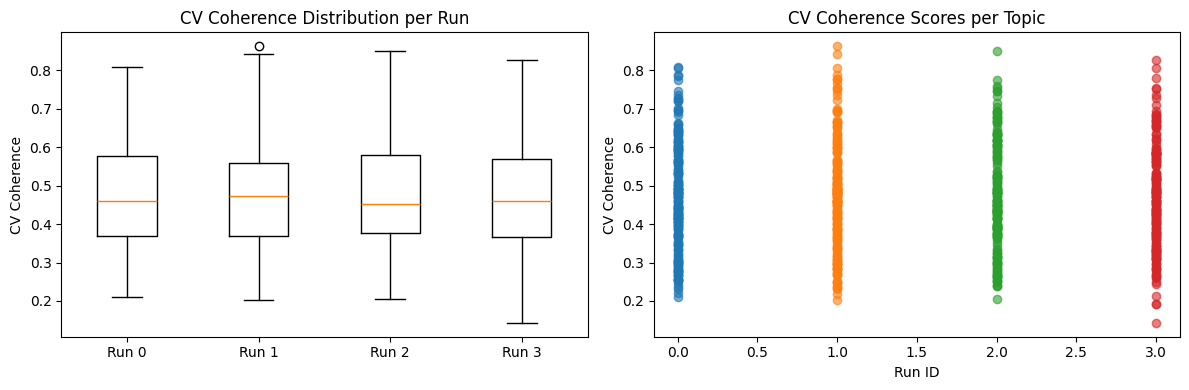

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_config import (
    GENSIM_PROCESS_COUNT, TOP_WORD_NUM
)
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_utils import plot_coherence
coherence_scores: List[List[float]] = []
id2word: Dictionary = Dictionary(clean_corpus)
for top_words_stats in top_words_list:
    current_model = CoherenceModel(
        topics=top_words_stats,
        texts=clean_corpus,
        dictionary=id2word,
        coherence='c_v',
        topn = TOP_WORD_NUM,
        processes=GENSIM_PROCESS_COUNT
    )
    current_coherence_scores = current_model.get_coherence_per_topic()
    coherence_scores.append(current_coherence_scores)
plot_coherence(coherence_scores)

### 3.3 Interpreting the coherence plots

The boxplot and scatter plot above show topic-level $C_v$ coherence distributions for
the four $K = 200$ MALLET runs used in this project. At a high level:

- **All runs are in the same ballpark.** Mean and median coherence values are tightly
  clustered around $\approx 0.47$ for all four seeds, with similar dispersion
  ($\text{std} \approx 0.13–0.14$). There is no single run whose topics are
  systematically more or less coherent than the others.
- **The left tail captures junk topics, not model collapse.** Each run exhibits a small
  tail of low-coherence topics (minima in the $\approx 0.17–0.23$ range), which correspond to
  boilerplate or highly heterogeneous word lists. This is expected in large topic
  models on news corpora.
- **No coherence-based winner.** Because the distributions overlap heavily, coherence
  alone does not justify promoting one seed over another. From a model-selection
  perspective, coherence is acting as a *veto* (ruling out obviously pathological
  runs) rather than an optimizer.

In the broader project, **final model choice is driven by out-of-sample regression and
trading performance**. Topic coherence plays a supporting role:

- as an **interpretability diagnostic**, giving a scalar summary of topic quality that
  can be reported alongside predictive metrics;
- as a **sanity check** that all candidate LDA runs produce reasonably coherent topics;
- and as a **tie-breaker** when multiple runs have similar predictive performance but
  differ in how much probability mass they allocate to clearly junk topics.

The metadata we persist below (`top_terms`, `cv_coherence`, and per-article exposures)
is used downstream to:

- label topics (`human_label`, `is_junk`) for qualitative analysis,
- experiment with excluding low-coherence topics from the regression design matrix,
- and provide an audit trail linking any regression coefficient back to an interpretable
  word list and coherence score.

In [ ]:
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_config import (
    SAMPLE_END_DATE, SAMPLE_START_DATE
)
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.coherence_measurement_utils import (
    extract_topic_exposure_dfs, generate_topic_metadata_dfs
)
from notebooks_utils.modeling_notebooks_utils.coherence_measurement_utils.lda_loading import load_lda_tables
topic_exposure_dfs: List[pd.DataFrame] = extract_topic_exposure_dfs(SAMPLE_START_DATE, SAMPLE_END_DATE)
topic_metadata_dfs: List[pd.DataFrame] = generate_topic_metadata_dfs(
    SAMPLE_START_DATE, SAMPLE_END_DATE, top_words_list, coherence_scores
)
lda_topic_exposure_loading_df: pd.DataFrame = pd.concat(topic_exposure_dfs, ignore_index=True)
lda_topic_metadata_loading_df: pd.DataFrame = pd.concat(topic_metadata_dfs, ignore_index=True)
load_lda_tables(lda_topic_exposure_loading_df, lda_topic_metadata_loading_df) # This is a No-OP if real_run is not set to TRUE.

> **Runtime note – LDA topic exposure ingestion**
>
> On a 2023 MacBook Pro (Apple M3), loading approximately **174 million** `(run_id, article_id, corpus_version, topic_id, topic_exposure)` rows into `lda_article_topic_exposure` via `load_lda_tables(...)` took about **152 minutes** (≈2.5 hours) using the default batch settings.
>
> The bulk load uses the helper functions in `utils/db_utils.py`, in particular `load_into_table(...)` with `BATCH_SIZE = 1000`. This step is intended as a one-off ingestion when (re)training LDA models. Most users should rely on the pre-populated Docker image / database dump rather than re-running this cell unless they explicitly need to rebuild the exposures table.
>
> Advanced users with more memory and I/O bandwidth can experiment with larger batch sizes by changing the `BATCH_SIZE` constant in `utils/db_utils.py` (for example, `10_000` or `50_000`) to trade off per-batch memory usage against wall-clock time for the insert.